
# MediChal Challenge - Detecting Malaria with cell Images

____

<div  style="background:#FFFFAA"> 
  
  <span style="color:red"> Le groupe vizualisation (Sakina Atia & Mathilde Lasseigne) ayant du mal à avoir accès à Internet et à leur notebook, elles n'ont pas pu s'occuper de le changer. </span> 

</div>

<img src="./logo.jpg" width="200" height="200" align="left"> 

## Team MEDICHAL :
- Théo Deschamps-Berger
- Simon Monteiro
- Xienneng Xu
- Nicolas Devatine
- Clément Veyssière
- Corentin Leloup
- Ramine Hamidi


<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p>
        <br>       
 
     
The problem we try to solve here is the diagnosis of malaria using images of cells that are whether infected or not. It is a binary classification problem from the data set found here at <a href=https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria>"Cell images for detecting malaria"</a>. The data set contains around 27 thousand images, that are balanced between the 2 classes. The way we proceed here is to extract features from the images instead of using images directly as inputs to the model we use for predictions.

 
</div>

<p align="center">
  <img src="example_cells.png">
</p>
<center>Example of parasitized and uninfected cells</center>

In [29]:
import sys
model_dir = 'sample_code_submission/'                        # Change the model to a better one once you have one!
result_dir = 'sample_result_submission/' 
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir); 
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide sample_data with the starting kit, but to prepare your submission, you must fetch the public_data from the challenge website and point to it.
    <br>
    <span style="color:red"> Just change the data name in the block below. In the rest of the section, replace the sample plots by anything you want. </span>
</div>

### Quality of the data

Our data is composed of images that we preprocessed to extract features. Therefore we do not have any missing data in any feature because we created the features ourselves. There may be one artefact which is the fact that the background is black, and we may wonder if infected cells might be smaller (or the contrary), which would provide us darker images and a higher (or lower) average of gray 

In [30]:
data_dir = 'public_data'              # Change this to the directory where you put the input data
data_name = 'malaria'

!ls $data_dir* # Linux command
# !dir $data_dir # Windows command

malaria_feat.name    malaria_test.data	     malaria_valid.data
malaria_label.name   malaria_train.data
malaria_public.info  malaria_train.solution


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" and "seaborn" built in functions to explore the data.

Reading public_data/malaria_train from AutoML format
Number of examples = 16534
Number of features = 19
         Class
0   uninfected
1  parasitized
Number of classes = 2


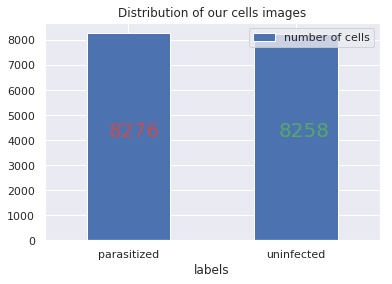

In [31]:
from data_io import read_as_df
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = read_as_df(data_dir  + '/' + data_name)                # The data are loaded as a Pandas Data Frame

nb_p=np.sum(data.target == 'parasitized')
nb_u=np.sum(data.target == 'uninfected')

p = pd.DataFrame({'labels':['parasitized', 'uninfected'],
                  'number of cells': [nb_p, nb_u]})
#ax = p.plot.hexbin(x='labels', y='number of cells', gridsize=25)
ax = p.plot.bar(x='labels', y='number of cells', rot=0),
plt.text(-0.12, nb_p/2, nb_p , size=20, color='r'),
plt.text(0.9, nb_u/2, nb_u , size=20, color='g'),
plt.title('Distribution of our cells images')
plt.show()

<div style="background:#009999 ">
Ici, on affiche simplement les données : On a 2 types d'images de cellules, celles infectées et celles saines. Cela nous permet d'avoir une idée globale des données qu'on va traiter par la suite. On peut penser à d’autres types de représentations comme un camembert, ou autres
On peut remarquer que la proportion de cellules saines et de cellules infectées est à peu près égale, ie en extrayant une cellule au hasard parmi cet ensemble, il y a autant de chance que la cellule soit infectée ou saine. Cela signifie que l’algorithme d’apprentissage que nous voulons mettre en place ne pourra se baser sur un pourcentage de chance de trouver une cellule infectée parmi les cellules saines et devra par conséquence analyser correctement l’image.
</div>

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f843d206550>,
      dtype=object)

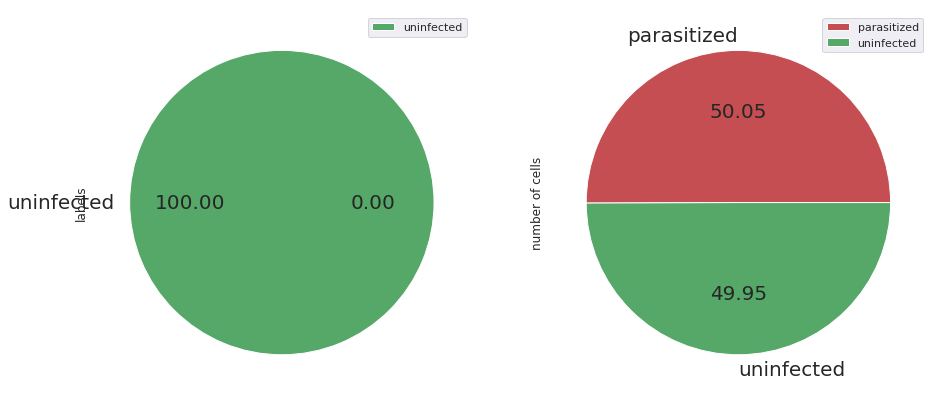

In [32]:
pf = pd.DataFrame({'labels':[0, 1],
                  'number of cells': [nb_p, nb_u]},
                   index = ['parasitized', 'uninfected'])
pf.plot(kind='pie', labels=['parasitized', 'uninfected'], colors=['r', 'g'],
        autopct='%.2f', fontsize=20, figsize=(15, 15), subplots=True)

<div style="background:#0082FA ">
On peut également représenter les données sous la forme d'un piechart (ou camembert). C'est une bonne façon de représenter les données car on a tout de suite les proportions des cellules infectées et des cellules non infectées
</div>

In [33]:
data.head()

,nb_black_pixels,var_color,mean_color,min_color,max_color,var_gray,mean_gray,min_gray,max_gray,nb_pixel_0.0_0.1,nb_pixel_0.1_0.2,nb_pixel_0.2_0.3,nb_pixel_0.3_0.4,nb_pixel_0.4_0.5,nb_pixel_0.5_0.6,nb_pixel_0.6_0.7,nb_pixel_0.7_0.8,nb_pixel_0.8_0.9,nb_pixel_0.9_1.0,target
0,4884,0.000000,0.948893,0.948893,0.948893,0.419515,0.636039,0.529412,0.764706,0,0,0,0,0,0,0,1038,9482,1886,uninfected
1,4347,0.000311,0.907223,0.874799,0.927769,0.519111,0.633702,0.400000,0.823529,0,0,0,0,0,1,79,6716,4333,656,parasitized
2,4935,0.000033,0.972043,0.962162,0.985586,0.266897,0.641619,0.568627,0.737255,0,0,0,0,0,0,0,0,8647,4506,uninfected
3,6501,0.000017,0.955153,0.950617,0.959436,0.594517,0.661221,0.301961,0.745098,0,0,0,0,4,25,122,367,8520,5813,parasitized
4,3384,0.000189,0.870487,0.857143,0.911565,2.217611,0.471401,0.345098,0.780392,0,0,0,0,0,1966,2513,1448,798,191,uninfected


We have decided to reduce the dataset of images to a simpler dataset with only 19 features.

`nb_black_pixels` counts pixels whose value is dark for gray_scale images, those around the cell in the image.

`var_color` feature is simply the empirical variance of the values of the pixels for colored images.

`mean_color` feature is simply the mean of the values of the pixels for colored images.

`max_color` is the maximum value for colored images.

`min_color` is the maximum value for colored images.

`var_gray`, `mean_gray`, `max_gray` and `min_gray` are the same but for gray-scale images.

`nb_pixel_i_j` is the number of pixels having their value (intensity : 0 = black | 1 = white) between i and j for gray-scale images.

In [34]:
data.describe() 

,nb_black_pixels,var_color,mean_color,min_color,max_color,var_gray,mean_gray,min_gray,max_gray,nb_pixel_0.0_0.1,nb_pixel_0.1_0.2,nb_pixel_0.2_0.3,nb_pixel_0.3_0.4,nb_pixel_0.4_0.5,nb_pixel_0.5_0.6,nb_pixel_0.6_0.7,nb_pixel_0.7_0.8,nb_pixel_0.8_0.9,nb_pixel_0.9_1.0
count,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.0,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000,16534.000000
mean,5186.434861,0.000187,0.932538,0.915922,0.951003,0.455423,0.638756,0.425941,0.767492,0.0,0.023588,0.068828,0.825390,9.424398,39.726261,255.600641,1700.682533,7205.277186,3425.218157
std,2555.612474,0.000685,0.042827,0.050649,0.038777,0.401030,0.047318,0.166523,0.034910,0.0,2.398723,3.554840,10.868906,34.948790,148.352439,944.844381,2869.953967,4015.087123,3777.575870
min,720.000000,0.000000,0.361582,0.308397,0.361582,0.013198,0.399673,0.062745,0.564706,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,3753.000000,0.000028,0.912136,0.892857,0.933333,0.169282,0.614504,0.262745,0.749020,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3781.000000,944.000000
50%,4641.000000,0.000070,0.942715,0.926871,0.960345,0.357243,0.646235,0.431373,0.764706,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,190.000000,7634.500000,1913.000000
75%,5848.500000,0.000161,0.963064,0.950949,0.978261,0.614151,0.671711,0.592157,0.788235,0.0,0.000000,0.000000,0.000000,3.000000,49.000000,108.000000,1966.000000,10215.000000,4317.750000
max,79306.000000,0.030410,1.000000,1.000000,1.000000,7.691629,0.748599,0.705882,0.941176,0.0,295.000000,305.000000,1026.000000,1595.000000,5492.000000,12863.000000,17071.000000,29463.000000,30574.000000


Histogram of our features:

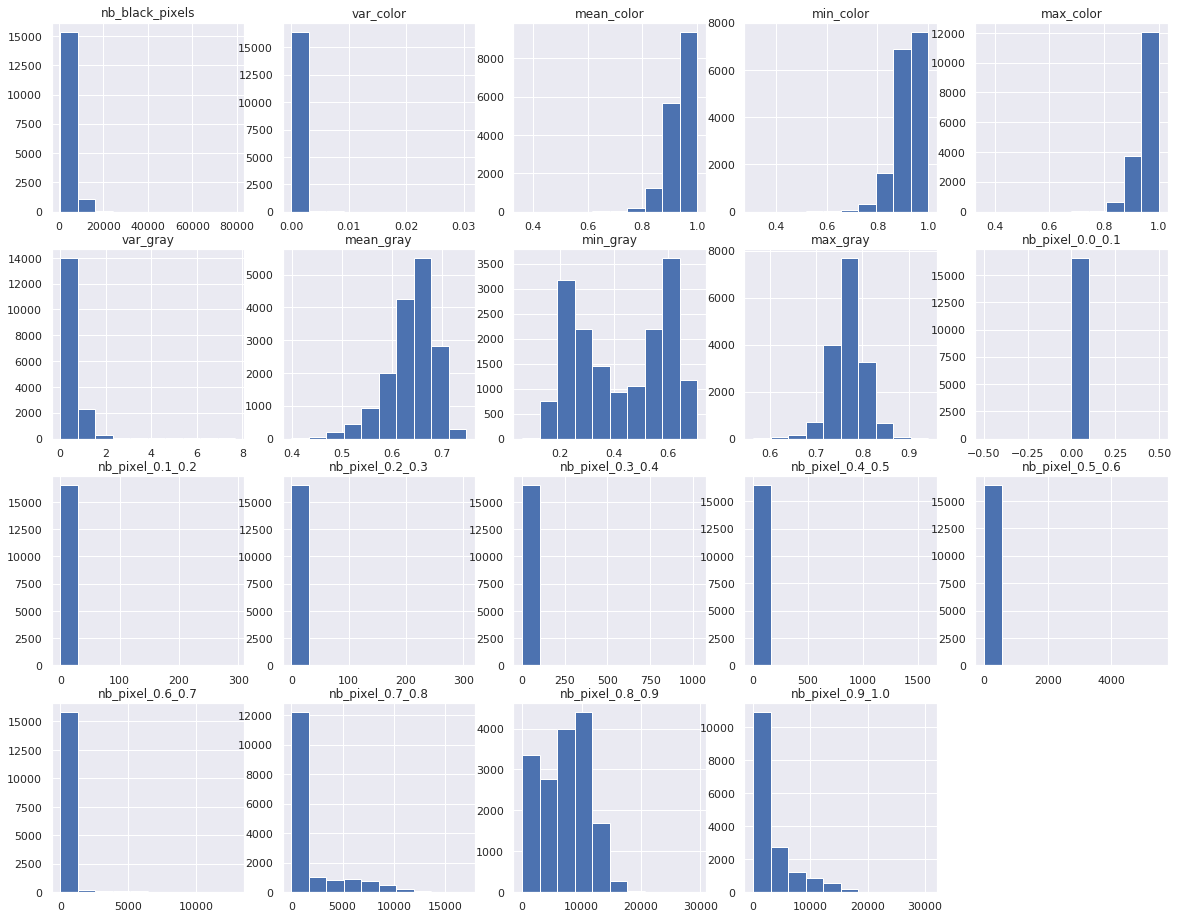

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,16))

for t in range(19):
    plt.subplot(4,5,t+1)
    plt.hist(data[data.columns[t]])
    plt.title(data.columns[t])
    t+=1

<div style="background:#009999 ">
Les histogrammes permettent de représenter les features fourni grâce au groupe preprocessing. Ils vont permettre de mieux visualiser les données en représentant l’analyse de chaque feature (moyenne, ecart-type, minimum,…) sur l’ensemble des données. Cela nous permet d’évaluer en partie leur pertinence et de commencer à les séléctionner.
</div>

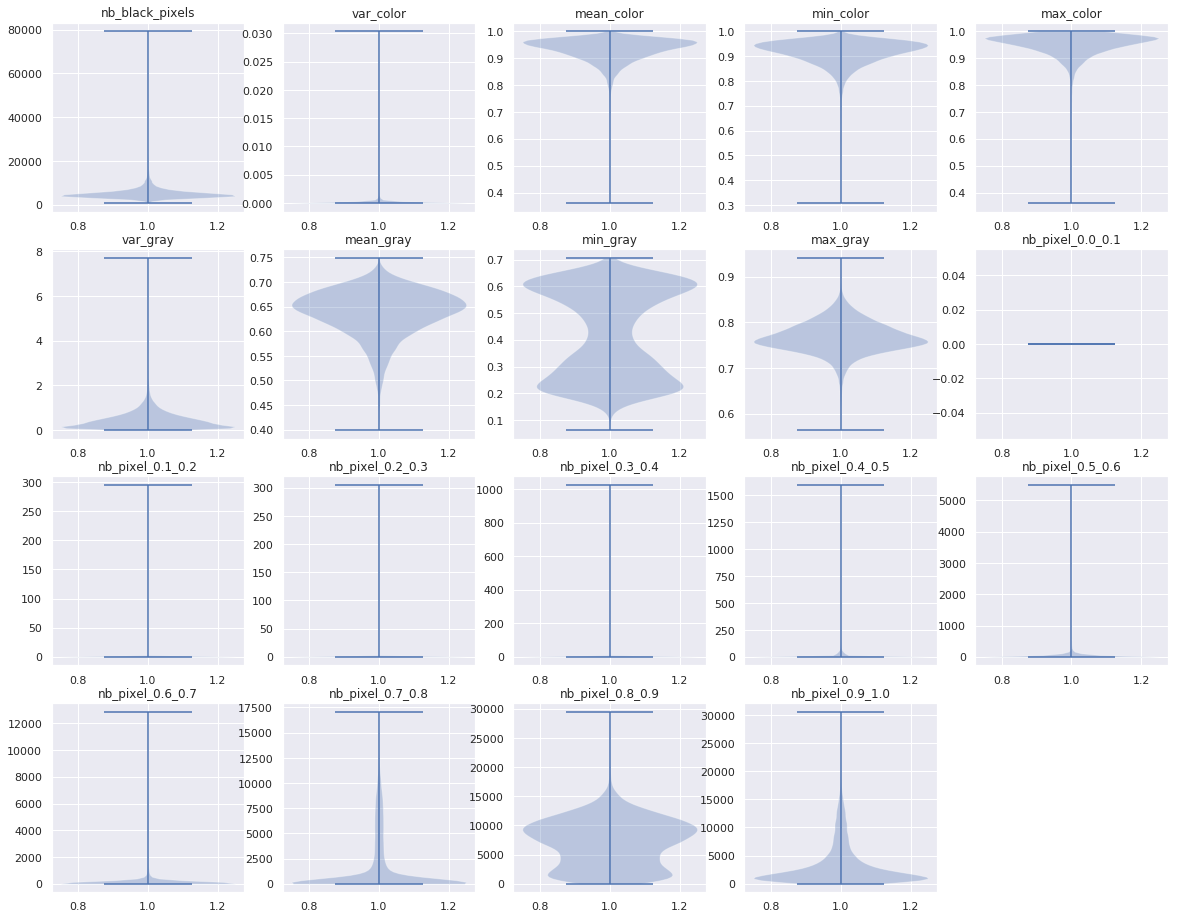

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,16))

for t in range(19):
    plt.subplot(4,5,t+1)
    plt.violinplot(data[data.columns[t]])
    plt.title(data.columns[t])
    t+=1

<div style="background:#0082FA ">
Pour représenter les features, on peut utiliser la représentation de notre choix, toutefois certaines se montreront bien plus pertientes. Ici par exemple, je trouve qu'il est préférable d'utiliser un histogramme plutôt qu'un violon. Je trouve le second diagramme moins facile à comprendre
</div>

<div style="background:#009999 ">
    
    
</div>

Let's try to indentify patterns with a pairplot, which will maybe give us structures for each class depending on 2 features.

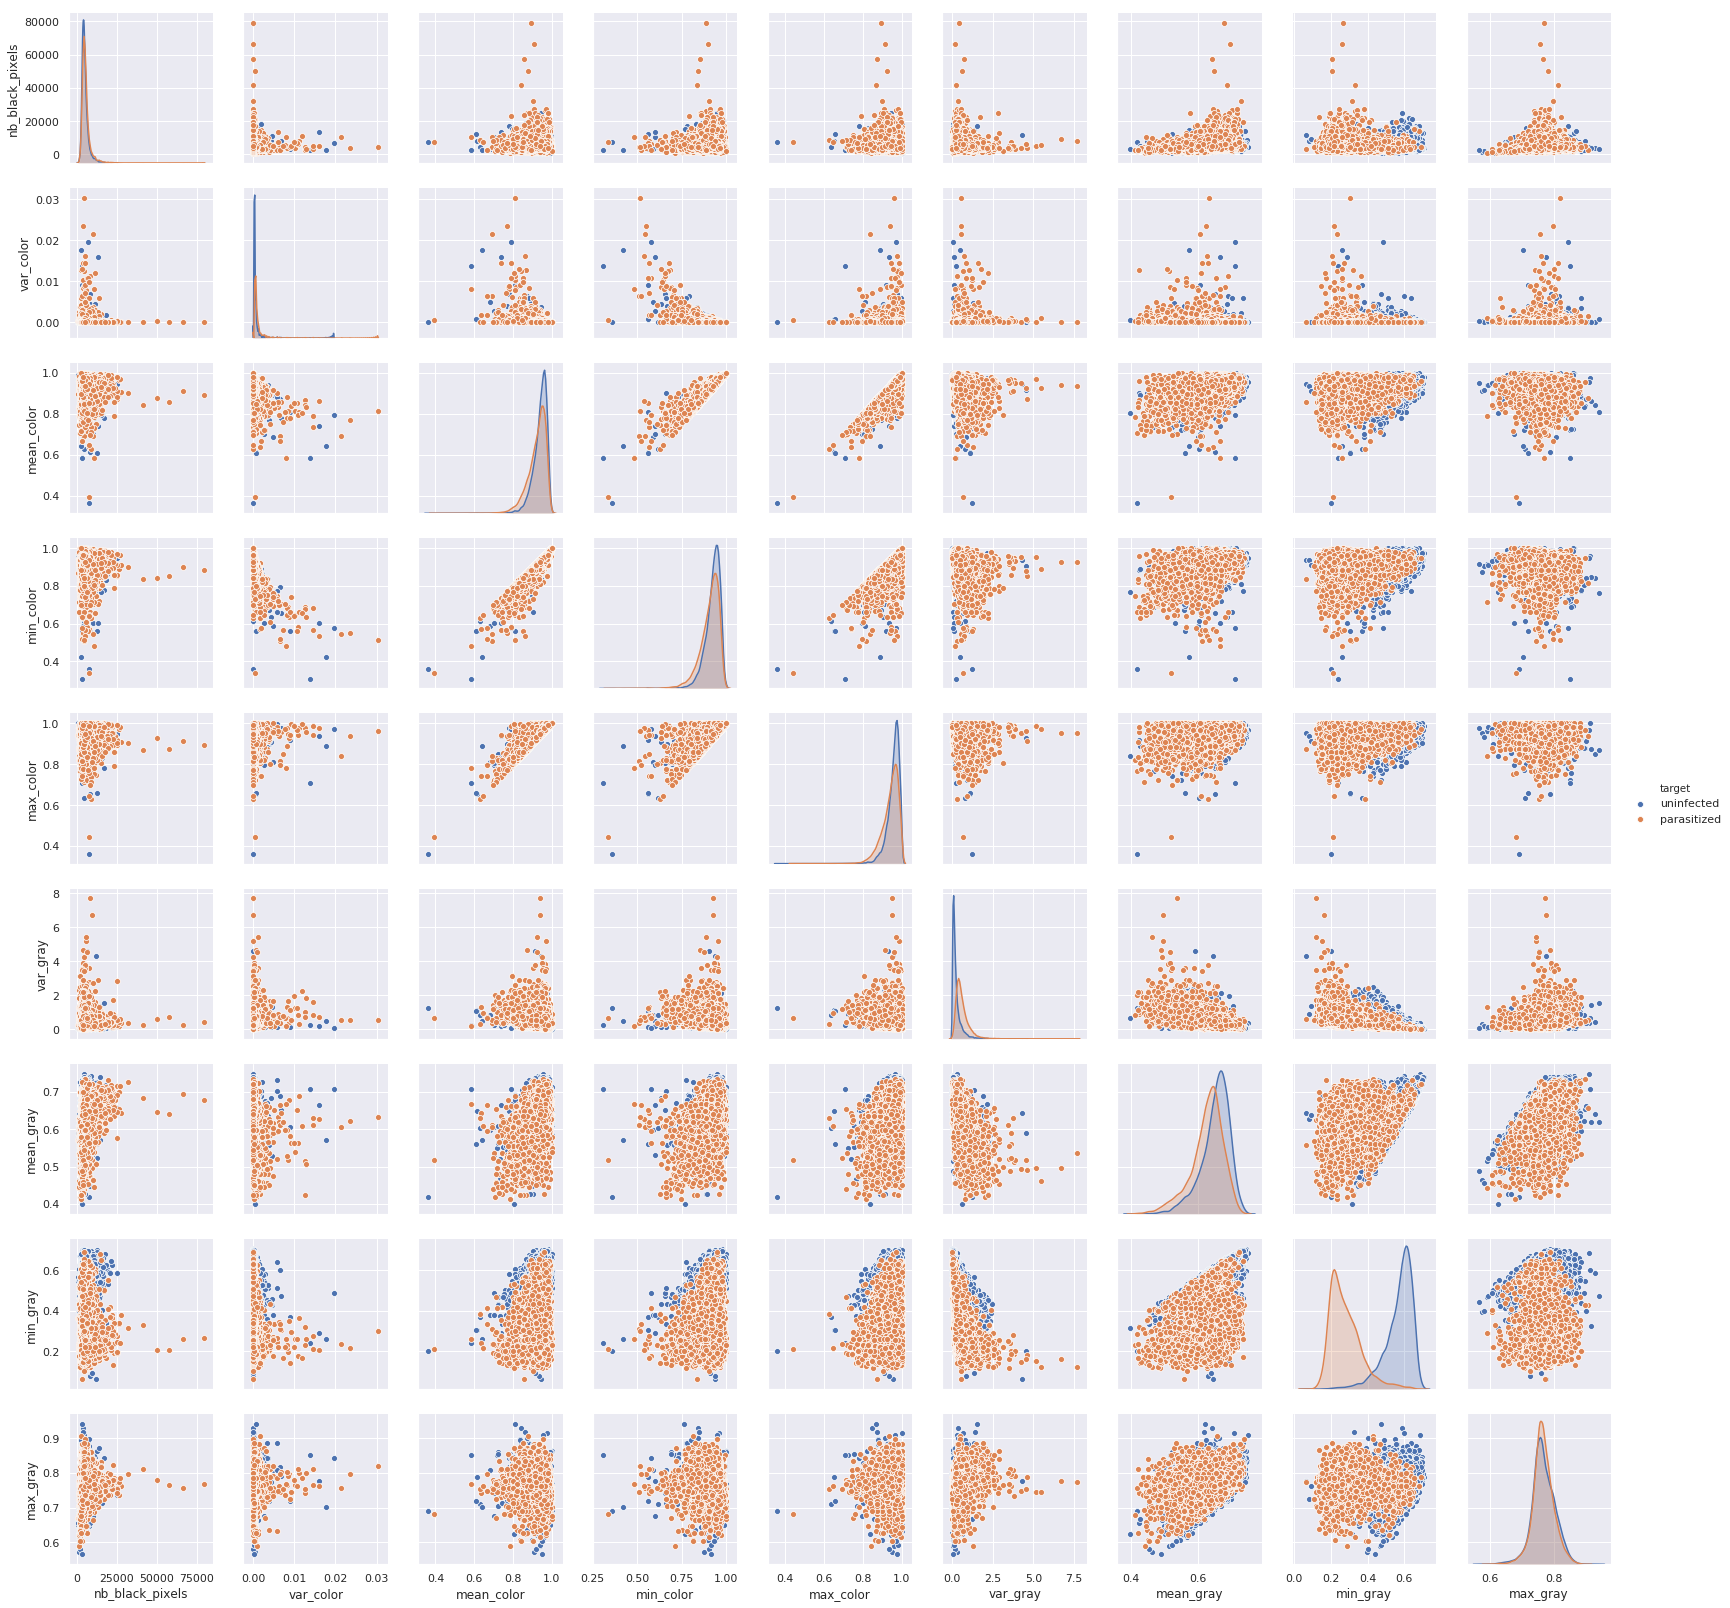

In [37]:
sns.pairplot(data[['target','nb_black_pixels',
                    'var_color','mean_color','min_color','max_color',
                   'var_gray','mean_gray','min_gray','max_gray']], hue="target")

<div style="background:#009999 ">
Ces graphes quant à eux, nous permettent d'obtenir un résultat plus visuel de l'analyse de ces features, en distinguant leur effet sur le fait qu'une cellule soit infectée ou non. Ils nous permettent de regarder à l'oeil nu quelles features sont le plus corrélé avec l'évaluation de la cellule, et donc quelles vont nous être les plus utiles. Cependant, cette représentation n’est pas la meilleure car elle ne permet pas de bien distinguer les features. Il serait plus intéressant de choisir un autre modèle, comme une matrice de corrélation.
</div>

Correlation of our features with the target: 'parasitized'

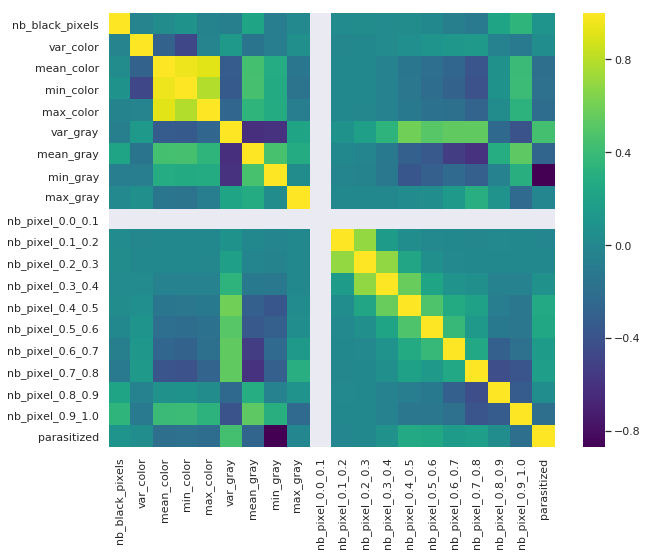

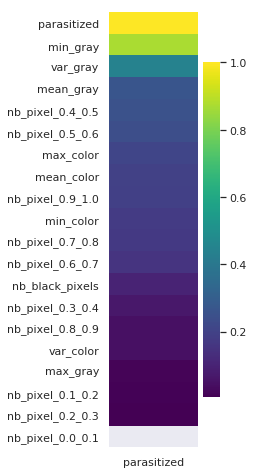

In [38]:
datatarget = pd.get_dummies(data['target'])['parasitized'].to_frame()
new_df = pd.merge(data, datatarget, right_index=True, left_index=True)
df_new = new_df.select_dtypes(include=np.number)

plt.figure(figsize = (10, 8))
ax = sns.heatmap(df_new.corr(),cmap="viridis", xticklabels=True, yticklabels=True)

d=pd.get_dummies(data['target'])['parasitized']

n_df = pd.merge(d.to_frame(), data, right_index=True, left_index=True)
df_n = n_df.select_dtypes(include=np.number).abs()


plt.figure(figsize = (2, 8))
ax = sns.heatmap(df_n.corr().abs().sort_values(['parasitized'], ascending=[0])["parasitized"].to_frame(), cmap="viridis", xticklabels=True, yticklabels=True)

<div style="background:#009999 ">
La matrice de corrélation va justement permettre de de voir quelles sont les features les plus pertinentes et celles qui sont inutiles: en traitant l'évaluation de la cellule comme une feature parmi d'autres, la table de corrélation va nous indiquer la valeur de la corrélation entre chaque features, une à une. En selectionnant la partie qui nous intéresse, il est donc possible d'obtenir uniquement la corrélation des features et de l'évaluation des cellules.

Le dernier graphique trie les features par rapport à leur corrélation : de la plus corrélée (qui ont le plus d’influence) à la moins corrélée sur le fait que la cellule soit parasitée ou pas. C’est ce qui va nous permettre de voir quelles sont les features à utiliser et celles à rejeter.
</div>

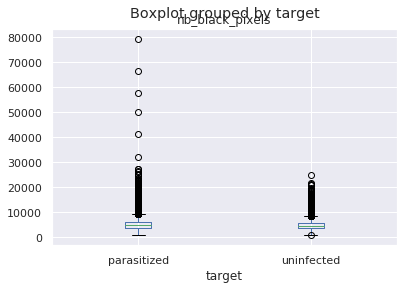

In [39]:
boxplot = data.boxplot(column=['nb_black_pixels'], by='target', )

There seem to have no correlation between the number of black pixels and the target as well, then there is no dataleakage.

<div style="background:#009999 ">
Ce graphe est celui de 2 boites à moustache (ou boxplot) correspondant à l'analyse de la feature nb_black_pixels, qui nous permet de voir facilement la valeur les quartiles, de la médiane et des extrémités. On peut remarquer dans ce graphique que le boxplot des cellules infectées et saines est très similaire, on peut donc en conclure qu’ils ne sont que peu corrélés.
</div>

From the correlation matrix, the feature that has the highest correlation with the target is "min_gray".

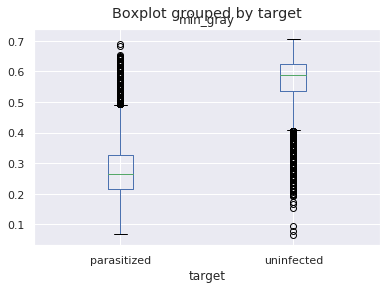

In [40]:
boxplot = data.boxplot(column=['min_gray'], by='target', )

<div style="background:#009999 ">
Au contraire dans ce graphique qui analyse la feature min_gray, on peut remarquer que les boxplot sont distantes et n'ont pas la même forme, bien qu'elles se trouvent sur la même échelle. Cela signifie que cette feature peut faire la différence entre les cellules infectées et saines bien plus aisément que la feature précédente. C'est d'ailleurs la feature avec la plus grande corrélation d'après  la matrice de confusion précédente.
</div>

## Model and results analysis

Here we run a sandbox test to introduce some metrics and ways to visualize results. We split the train set into train and test in order to perform these analysis, and we compute the confusion matrix for RandomForestClassifier with arbitrary hyper-parameters.

In [41]:
from sklearn.model_selection import train_test_split
from data_manager import DataManager
from model import model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ParameterGrid

D = DataManager(data_name, data_dir, replace_missing=True)
# Séparation de l'ensemble d'apprentissage en un plus petit ensemble d'apprentissage et un ensemble de test
X_train, X_test, Y_train, Y_test = train_test_split(D.data['X_train'], D.data['Y_train'], test_size=0.33, random_state=42)

# Load model
clf = RandomForestClassifier(random_state = 42, n_estimators = 2, max_depth = 5)
M = model() # The model is by default a random forest classifier

if not(M.is_trained):
    M.fit(X_train_pre, y_train_pre)                     

Y_hat_test_pre = M.predict(X_test_pre)

from sklearn.metrics import confusion_matrix
confusion_matrix(y_test_pre, Y_hat_test_pre)

Info file found : /home/tp-home003/mvincen1/L2/S4/malaria/starting_kit/public_data/malaria_public.info
FIT: dim(X)= [11077, 19]
FIT: dim(y)= [11077, 1]
PREDICT: dim(X)= [5457, 19]
PREDICT: dim(y)= [5457, 1]


array([[2570,  105],
       [ 158, 2624]])

This is the plot of the confusion matrix from the predictions performed.

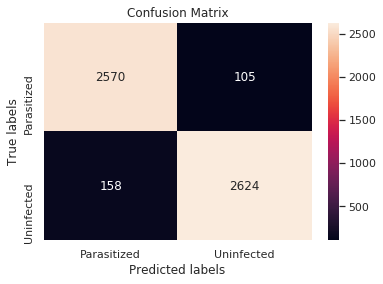

In [42]:
ax= plt.subplot()
sns.heatmap(confusion_matrix(y_test_pre, Y_hat_test_pre), annot=True, fmt='g', ax=ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Parasitized', 'Uninfected']);
ax.yaxis.set_ticklabels(['Parasitized', 'Uninfected']);
plt.show()

<div style="background:#009999 ">
La matrice de confusion est un outil très important de l'analyse de l'efficacité d'un modèle d'apprentissage automatique. Ainsi, elle nous permet de savoir à quel point le model réussi à classer correctement les données d'apprentissage. On peut ici remarquer que peu de données ont été mal classées : seulement 130 cellules non infectées ont été classifiées comme infectées par le model et, plus important, 107 cellules ont été classifiée comme saines par le model alors qu'elles étaient infectées.
C'est ce dernier chiffre qu'il va nous falloir diminuer au maximum car cette erreur est celle ayant le plus de conséquence et est contraire au but même de notre analyse (qui est de trouver les cellules infectées). On peut également remarquer ici que la plupart des cellules ont été classées correctement, ce qui montre que le nombre d'erreurs du model actuel reste faible.
</div>

In [43]:
from sklearn.metrics import classification_report

target_names = ['Parasitized', 'Uninfected']
print(classification_report(y_test_pre, Y_hat_test_pre, target_names=target_names))

              precision    recall  f1-score   support

 Parasitized       0.94      0.96      0.95      2675
  Uninfected       0.96      0.94      0.95      2782

   micro avg       0.95      0.95      0.95      5457
   macro avg       0.95      0.95      0.95      5457
weighted avg       0.95      0.95      0.95      5457



In [49]:
# Lien entre readme model et readme visualization
# Affichage des matrices de confusion pour chaque algorithme

# Récupération des fichiers de prédiction de chaque algorithme
files_predict = !ls sample_result_submission/malaria_*_test.predict
print(files_predict)

['sample_result_submission/malaria_F_test.predict', 'sample_result_submission/malaria_KN_test.predict', 'sample_result_submission/malaria_MLP_test.predict', 'sample_result_submission/malaria_P_test.predict', 'sample_result_submission/malaria_T_test.predict']


In [50]:
# Renvoie le nparray des labels prédits enregistrés dans un fichier
def nparray_predict(file_predict):
    print("File predict =", file_predict)
    with open(file_predict, "r") as f:
        res = f.read().split("\n")
        res.remove("")
    return np.array([int(i) for i in res])

In [51]:
# Affiche la matrice de confusion sur l'ensemble de test
def plot_confusion_matrix(Y_test_predict):
    global Y_test
    ax = plt.subplot()
    #annot=True to annotate cells
    sns.heatmap(confusion_matrix(Y_test, Y_test_predict), annot=True, fmt='g', ax=ax)

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['Parasitized', 'Uninfected']);
    ax.yaxis.set_ticklabels(['Parasitized', 'Uninfected']);
    plt.show()

File predict = sample_result_submission/malaria_F_test.predict


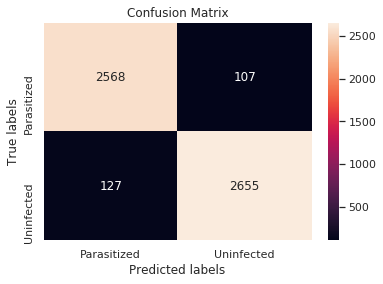

File predict = sample_result_submission/malaria_KN_test.predict


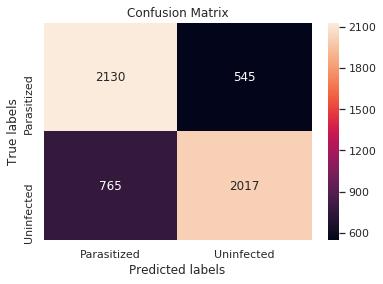

File predict = sample_result_submission/malaria_MLP_test.predict


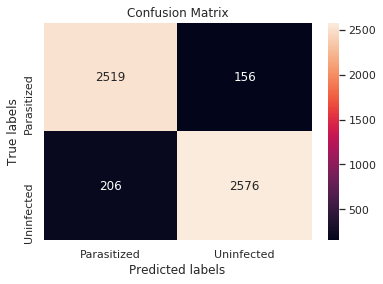

File predict = sample_result_submission/malaria_P_test.predict


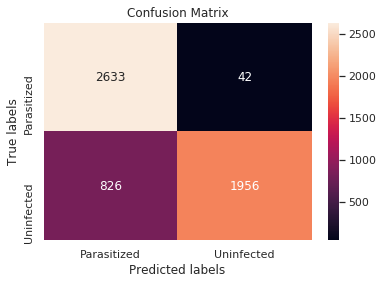

File predict = sample_result_submission/malaria_T_test.predict


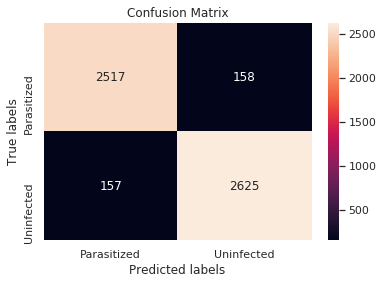

In [52]:
# Affichage des matrices de confusion pour chaque algorithme
for file_predict in files_predict:
    plot_confusion_matrix(nparray_predict(file_predict))

Then we can compute the AUC metric which is the one used for the submission.

<div style="background:#FFFFAA">
    <h2>Training a predictive model</h2>
    <p>
We provide an example of predictive model (for classification or regression) in the `sample_code_submission/` directory. It is a quite stupid model: it makes constant predictions. Replace it with your own model.
    </div>

In [16]:
from data_io import write
from model import model
# Uncomment the next line to show the code of the model
#??model

<div style="background:#FFFFAA">
an instance of the model (run the constructor) and attempt to reload a previously saved version from `sample_code_submission/`:
    
</div>

<div style="background:#FFFFAA">
<h1>Step 2: Building a predictive model</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with DataManager</h2>
    <p>
We reload the data with the AutoML DataManager class because this is more convenient:
   <br>     <span style="color:red"> Keep this, it illustrates how data in AutoML formal are loaded by the ingestion program </span>
</div>

In [17]:
from data_manager import DataManager
D = DataManager(data_name, data_dir, replace_missing=True)
print(D)

Info file found : /home/tp-home005/satia/Semestre4/projects/malaria/starting_kit/public_data/malaria_public.info
DataManager : malaria
info:
	usage = Malaria cell images dataset
	name = malaria
	task = binary.classification
	target_type = Numerical
	feat_type = Numerical
	metric = roc_auc_score
	time_budget = 1200
	feat_num = 19
	target_num = 2
	label_num = 2
	train_num = 16534
	valid_num = 5512
	test_num = 5512
	has_categorical = 0
	has_missing = 0
	is_sparse = 0
	format = dense
data:
	X_train = array(16534, 19)
	Y_train = array(16534,)
	X_valid = array(5512, 19)
	Y_valid = array(0,)
	X_test = array(5512, 19)
	Y_test = array(0,)
feat_type:	array(19,)
feat_idx:	array(0,)



In [18]:
#Trying a random forest model
M = model()   #The model is by default a random forest classifier
trained_model_name = model_dir + data_name
# Uncomment the next line to re-load an already trained model
#M = M.load(trained_model_name)                  

<div style="background:#FFFFAA">
    Train the model (unless you reloaded a trained model) and make predictions. 
</div>

In [19]:
if not(M.is_trained):
    X_train = D.data['X_train']
    Y_train = D.data['Y_train']
    M.fit(X_train, Y_train)                     

Y_hat_train = M.predict(D.data['X_train']) # Optional, not really needed to test on taining examples
Y_hat_valid = M.predict(D.data['X_valid'])
Y_hat_test = M.predict(D.data['X_test'])

FIT: dim(X)= [16534, 19]
FIT: dim(y)= [16534, 1]
PREDICT: dim(X)= [16534, 19]
PREDICT: dim(y)= [16534, 1]
PREDICT: dim(X)= [5512, 19]
PREDICT: dim(y)= [5512, 1]
PREDICT: dim(X)= [5512, 19]
PREDICT: dim(y)= [5512, 1]


<div style="background:#FFFFAA">
    <b> Save the trained model </b> (will be ready to reload next time around) and save the prediction results. IMPORTANT: if you save the trained model, it will be bundled with your sample code submission. Therefore your model will NOT be retrained on the challenge platform. Remove the pickle from the submission if you want the model to be retrained on the platform.
</div>

In [20]:
M.save(trained_model_name)                 
result_name = result_dir + data_name
from data_io import write
write(result_name + '_train.predict', Y_hat_train)
write(result_name + '_valid.predict', Y_hat_valid)
write(result_name + '_test.predict', Y_hat_test)
!ls $result_name*

sample_result_submission/malaria_test.predict
sample_result_submission/malaria_train.predict
sample_result_submission/malaria_valid.predict


<div style="background:#FFFFAA">
    <h2>Scoring the results</h2>
    <h3>Load the challenge metric</h3>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    </div>

We use the area under the curve as our metric to evaluate our model for the moment. We chose this metric because accuracy gives us only the percentage of correctly classified examples, whereas what we are interested in is to have the lowest possible rate of false negatives (infected cells classifies as being healthy). The ROC curve we will get will help us to find a good threshold for this classification, which will not necessarily the one maximising the accuracy as the false negatives are critical in our case (but the true negatives can always be rechecked by experts). The AUC will then give us the general performance of our model given the fact that we want to maximize true positives and true negatives.

In [21]:
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: roc_auc_score


<div style="background:#FFFFAA">
    <h3> Training performance </h3>
    <p>
The participants normally posess target values (labels) only for training examples (except for the sample data). We compute with the `example` metric the training score, which should be zero for perfect predictions.
        </div>

In [22]:
print('Training score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_hat_train))
print('Ideal score for the', metric_name, 'metric = %5.4f' % scoring_function(Y_train, Y_train))

Training score for the roc_auc_score metric = 0.9958
Ideal score for the roc_auc_score metric = 1.0000


You can add here other scores and result visualization.

In [23]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Y_train, Y_hat_train)

array([[8252,    6],
       [  64, 8212]])

In [24]:
from sklearn.metrics import roc_curve, auc

size = round(len(D.data['X_train'])/10)

probas_ = M.classifier.fit(D.data['X_train'][:size], D.data['Y_train'][:size].ravel()).predict_proba(D.data['X_train'][size:])
# Compute ROC curve and area the curve
fpr, tpr, thresholds = roc_curve(D.data['Y_train'][size:].ravel(), probas_[:, 1])
roc_auc = auc(fpr, tpr)

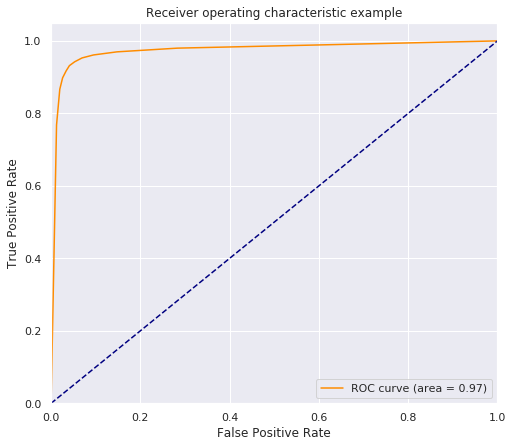

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 7))

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

This plot of the ROC curve is a good indicator for us to find a good threshold for our model, here we will prefer a very low rate of false negatives (1 - true positives rate). If we really want something near to 100% true positives, we might consider a model giving us 40% of false positive rate, we might consider that threshold as a medical diagnosis is a critical application.

<div style="background:#009999 ">
L'utilisation du ROC peut venir en complément à la matrice de confusion. En effet bien que la matrice de confusion nous permette de savoir exactement le nombre d'erreurs et quel type d'erreur a été fait, la ROC nous permet de connaitre plus facilement et rapidement l'efficacité d'un modèle.
On peut remarquer ici que la valeur ROC est de 0.98, sachant qu'un test ayant une précision parfaite aura une valeur de 1 et un test se basant sur la chance une valeur de 0.5. On peut donc considérer que la valeur qui nous est donnée ici est très haute et le modèle étudié est très efficace. En effet la valeur affectée aux faux négatifs est très faible (de 0.02) ce qui signifie que le nombre d'erreur du modèle est très bas.
</div>

<div style="background:#FFFFAA">
    <h3>Cross-validation performance</h3>
    <p>
The participants do not have access to the labels Y_valid and Y_test to self-assess their validation and test performances. But training performance is not a good prediction of validation or test performance. Using cross-validation, the training data is split into multiple training/test folds, which allows participants to self-assess their model during development. The average CV result and 95% confidence interval is displayed.
   </div>

In [26]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
M= model ()
scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
scores

FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13228, 19]
FIT: dim(y)= [13228, 1]
PREDICT: dim(X)= [3306, 19]
PREDICT: dim(y)= [3306, 1]

CV score (95 perc. CI): 0.95 (+/- 0.01)


array([0.9536122 , 0.95384373, 0.94671811, 0.95639702, 0.95031821])

In [27]:
data2 = data.drop(['nb_black_pixels'], axis=1)
X_train2 = data2.drop(['target'], axis= 1)
X_train2
M = model()
scores = cross_val_score(M, X_train2, Y_train, cv=5, scoring=make_scorer(scoring_function))
print('\nCV score without the black_pixels attribute (95 perc. CI): %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))
scores

FIT: dim(X)= [13227, 18]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 18]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 18]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 18]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 18]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 18]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 18]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 18]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13228, 18]
FIT: dim(y)= [13228, 1]
PREDICT: dim(X)= [3306, 18]
PREDICT: dim(y)= [3306, 1]

CV score without the black_pixels attribute (95 perc. CI): 0.95 (+/- 0.00)


array([0.95146811, 0.95263833, 0.94883625, 0.95395398, 0.95033651])

The scores of our model with and without the nb_black_pixels attribute is the same. Therefore we can conclude that there is no data leakage.

____

### Feature importance

The advantage of using a Random forest models is that we can evaluate which feature in taken into account  when predicting the target classes, here you can have an idea of which feature was the most relevant for solving our task

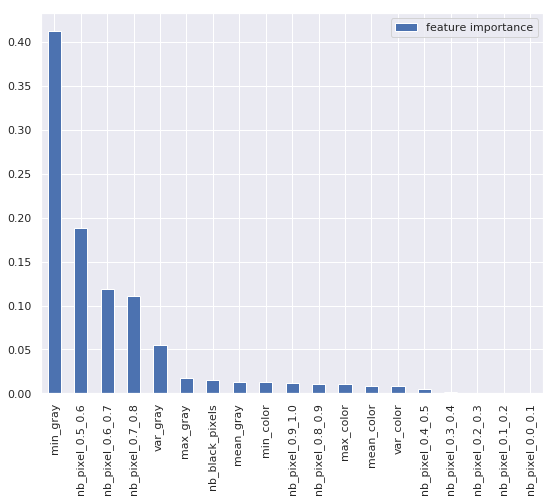

In [28]:
import pandas as pd

feature_importance = pd.DataFrame(M.classifier.feature_importances_,index= list(data)[:19], columns=['feature importance']).sort_values('feature importance', ascending = False)
feature_importance.plot.bar(figsize=(9,7))
plt.show()

<div style="background:#009999 ">
Ce  graphique montre à quel point une feature joue un rôle important dans la classification de nos données. Ici, on observe que min_gray joue un rôle clé.
Un autre moyen de selectionner les features les plus utiles restent d'utiliser la fonction .featureimportances sur une panda DataFrame. Ainsi, l'algorithme va calculer l'importance des features par lui-même. Ici on peut voir que, comme on avait pu le remarquer avant, la feature min_gray est choisie comme étant la plus importante, les suivantes étant certains nombres de pixels. On peut donc voir que bien que nos graphiques précédents étaient justes, il est plus efficace d'utiliser cette fonction.
</div>

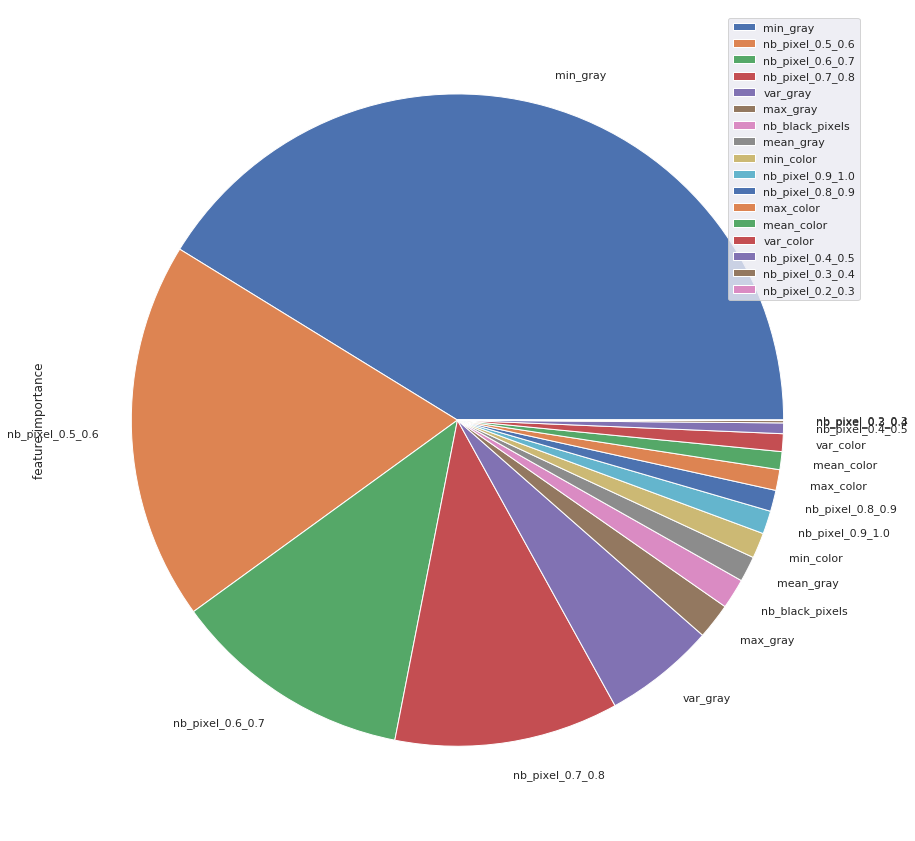

In [29]:
import pandas as pd

feature_importance = pd.DataFrame(M.classifier.feature_importances_,index= list(data)[:19], columns=['feature importance']).sort_values('feature importance', ascending = False)
feature_importance.plot.pie(subplots=True, figsize=(15,15))
plt.show()

<div style="background:#0082FA ">
On peut de nouveau représenter l'importance des features avec un pie chart. Il met tout de suite en avant celles qui le sont par une plus grande proportion sur le graphe
Ici on observe bien que min_gray est la feature la plus importante, suivi de nb_pixel_0.5_0.6
</div>



<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [30]:
!source activate python3; python $problem_dir/ingestion.py $data_dir $result_dir $problem_dir $model_dir

/bin/sh: 1: source: not found
Using input_dir: /home/tp-home005/satia/Semestre4/projects/malaria/starting_kit/public_data
Using output_dir: /home/tp-home005/satia/Semestre4/projects/malaria/starting_kit/sample_result_submission
Using program_dir: /home/tp-home005/satia/Semestre4/projects/malaria/starting_kit/ingestion_program
Using submission_dir: /home/tp-home005/satia/Semestre4/projects/malaria/starting_kit/sample_code_submission
Traceback (most recent call last):
  File "ingestion_program//ingestion.py", line 137, in <module>
    import data_io                       # general purpose input/output functions
  File "/home/tp-home005/satia/Semestre4/projects/malaria/starting_kit/ingestion_program/data_io.py", line 25, in <module>
    import pandas as pd
ImportError: No module named pandas


<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [31]:
scoring_output_dir = 'scoring_output'
!python $score_dir/score.py $data_dir $result_dir $scoring_output_dir

Traceback (most recent call last):
  File "scoring_program//score.py", line 22, in <module>
    import yaml
ImportError: No module named yaml


## Parameter optimization to try to improve the area under the roc curve.

In [32]:
from sklearn.model_selection import ParameterGrid
from sklearn.ensemble import RandomForestClassifier

# import os
# import sys
# sys.stdout = open(os.devnull, 'w')

# Define the hyperparameters
hyperparameters = {
    'max_depth': [5, 10, 20,40], 
    'n_estimators' : [2,10, 20, 100] }

# Compute all combinations
parameter_grid = list(ParameterGrid(hyperparameters))

# Just a table to save the results
#resultsDF = pd.DataFrame(columns=['factors', 'regularization', 'alpha', 'auc'])
resultsDF = pd.DataFrame()

for parameter_combination in parameter_grid:    
    clf = RandomForestClassifier (random_state = 42, n_estimators =parameter_combination['n_estimators'],max_depth =parameter_combination['max_depth'])
    M = model (classifier=clf)
    
    
    scores = cross_val_score(M, X_train, Y_train, cv=5, scoring=make_scorer(scoring_function))
    
    
    parameter_combination['auc'] = scores.mean()
    
    resultsDF = resultsDF.append(parameter_combination, ignore_index=True)
    
res = resultsDF.sort_values(by=['auc'], ascending=False)


FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13228, 19]
FIT: dim(y)= [13228, 1]
PREDICT: dim(X)= [3306, 19]
PREDICT: dim(y)= [3306, 1]
FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13227, 19]
FIT: dim(y)= [13227, 1]
PREDICT: dim(X)= [3307, 19]
PREDICT: dim(y)= [3307, 1]
FIT: dim(X)= [13228, 19]
FIT: dim(y)= [13228, 1]
PREDICT: dim(X)

PREDICT: dim(X)= [3306, 19]
PREDICT: dim(y)= [3306, 1]


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

</div>

In [33]:
import datetime 
from data_io import zipdir

the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = '../sample_code_submission_' + the_date + '.zip'
sample_result_submission = '../sample_result_submission_' + the_date + '.zip'
zipdir(sample_code_submission, model_dir)
zipdir(sample_result_submission, result_dir)
print("Submit one of these files:\n" + sample_code_submission + "\n" + sample_result_submission)

Submit one of these files:
../sample_code_submission_20-03-03-18-30.zip
../sample_result_submission_20-03-03-18-30.zip
